# Kaggle: [Cassava Leaf Disease Classification](https://www.kaggle.com/c/cassava-leaf-disease-classification/overview)


## Setup environment 

- connect the gDrive with dataset
- extract data to local
- install pytorch lightning

In [1]:
from google.colab import drive

# connect to  my gDrive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [2]:
# copy the dataset to local drive
! cp /content/gdrive/Shareddrives/Datasets/cassava-leaf-disease-classification.zip .

In [3]:
# extract dataset to the drive
! unzip -q cassava-leaf-disease-classification.zip
! ls -l

total 6041812
-rw------- 1 root root 6185662420 Apr  2 16:57 cassava-leaf-disease-classification.zip
drwx------ 6 root root       4096 Apr  2 16:55 gdrive
-rw-r--r-- 1 root root        172 Nov 25 16:35 label_num_to_disease_map.json
drwxr-xr-x 1 root root       4096 Mar 25 13:38 sample_data
-rw-r--r-- 1 root root         32 Nov 25 16:35 sample_submission.csv
drwxr-xr-x 2 root root       4096 Apr  2 16:57 test_images
drwxr-xr-x 2 root root       4096 Apr  2 16:57 test_tfrecords
-rw-r--r-- 1 root root     358283 Nov 25 16:35 train.csv
drwxr-xr-x 2 root root     753664 Apr  2 16:58 train_images
drwxr-xr-x 2 root root       4096 Apr  2 16:59 train_tfrecords


In [4]:
! pip install -q pytorch-lightning torchmetrics
! pip install -q https://github.com/Borda/kaggle_cassava-leaf-disease/archive/main.zip

# import os
# os.kill(os.getpid(), 9)
! pip list | grep torch

pytorch-lightning             1.2.6         
torch                         1.8.1+cu101   
torchmetrics                  0.2.0         
torchsummary                  1.5.1         
torchtext                     0.9.1         
torchvision                   0.9.1+cu101   


In [5]:
! nvidia-smi

Fri Apr  2 16:59:35 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Data exploration

In [6]:
%matplotlib inline

import json
from pprint import pprint

import pandas as pd

path_csv = "/content/train.csv"
train_data = pd.read_csv(path_csv)
print(train_data.head())

label_mapping = json.load(open("/content/label_num_to_disease_map.json"))
label_mapping = {int(k): v for k, v in label_mapping.items()}
pprint(label_mapping)

         image_id  label
0  1000015157.jpg      0
1  1000201771.jpg      3
2   100042118.jpg      1
3  1000723321.jpg      1
4  1000812911.jpg      3
{0: 'Cassava Bacterial Blight (CBB)',
 1: 'Cassava Brown Streak Disease (CBSD)',
 2: 'Cassava Green Mottle (CGM)',
 3: 'Cassava Mosaic Disease (CMD)',
 4: 'Healthy'}


{0: 1087, 1: 2189, 2: 2386, 3: 13158, 4: 2577}


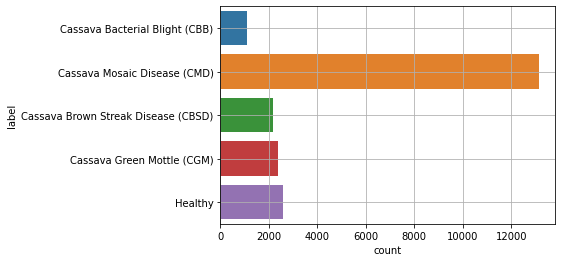

In [7]:
import numpy as np
import seaborn as sns

lb_hist = dict(zip(range(10), np.bincount(train_data["label"])))
pprint(lb_hist)

ax = sns.countplot(y=train_data["label"].map(label_mapping), orient="v")
ax.grid()

(-0.5, 799.5, 599.5, -0.5)

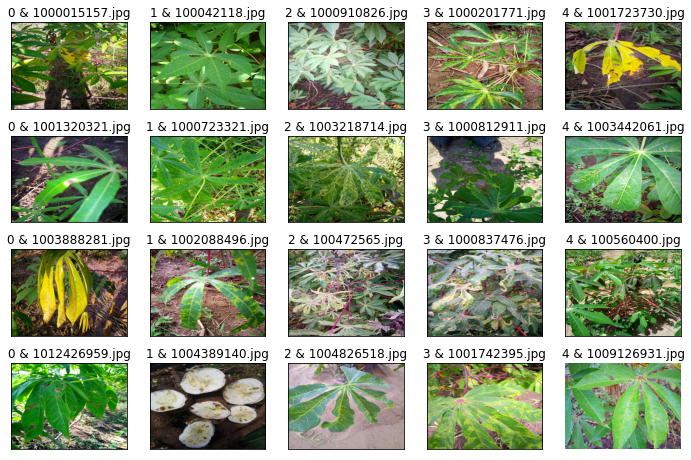

In [8]:
import matplotlib.pyplot as plt

fig, axarr = plt.subplots(nrows=4, ncols=5, figsize=(12, 8))
for lb, df_ in train_data.groupby("label"):
    img_names = list(df_["image_id"])
    for i in range(4):
        img_name = img_names[i]
        img = plt.imread(f"/content/train_images/{img_name}")
        axarr[i, lb].imshow(img)
        axarr[i, lb].set_title(f"{lb} & {img_name}")
        axarr[i, lb].set_xticks([])
        axarr[i, lb].set_yticks([])
plt.axis("off")

In [9]:
import os

import tqdm

# clr_images = {0: [], 1: [], 2: []}
# # just some smaller subset bc there is some random freezing without proper error/exception
# for img_name in tqdm.tqdm(list(train_data['image_id'])[:1000]):
#   img = plt.imread(os.path.join("/content/train_images", img_name))
#   # aggregate means per channel
#   for i in range(3):
#     clr_images[i].append(np.mean(img[..., i]))

# img_color_mean = [np.mean(clr_images[i]) for i in range(3)]
# pprint(np.array(img_color_mean) / 255.0)

100%|██████████| 1000/1000 [00:08<00:00, 114.19it/s]

array([0.43138918, 0.4989732 , 0.31300829])


In [10]:
# clr_images = {0: [], 1: [], 2: []}
# # just some smaller subset bc there is some random freezing without proper error/exception
# for img_name in tqdm.tqdm(list(train_data['image_id'])[:800]):
#   img = plt.imread(os.path.join("/content/train_images", img_name))
#   # compute STD per channel
#   for i in range(3):
#     std = np.sqrt(np.mean((img[..., i] - img_color_mean[i]) ** 2))
#     clr_images[i].append(np.mean(std))

# img_color_std = [np.mean(clr_images[i]) for i in range(3)]
# pprint(np.array(img_color_std) / 255.0)

100%|██████████| 800/800 [00:09<00:00, 87.32it/s]

array([0.23725494, 0.23952537, 0.2272112 ])


## DataModule

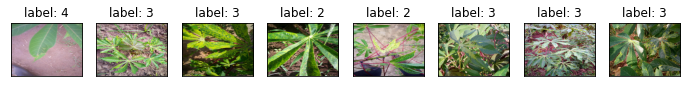

In [11]:
from kaggle_imgclassif.cassava.data import CassavaDataset

dataset = CassavaDataset()

# quick view
fig = plt.figure(figsize=(12, 4))
for i in range(8):
    img, lb = dataset[i]
    ax = fig.add_subplot(1, 8, i + 1, xticks=[], yticks=[])
    ax.imshow(img)
    ax.set_title(f"label: {lb}")

batch labels: {0: 6, 1: 18, 2: 14, 3: 82, 4: 8}
image size: torch.Size([3, 224, 224])


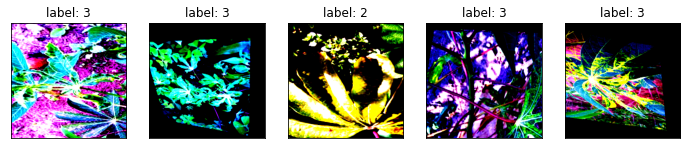

In [12]:
from kaggle_imgclassif.cassava.data import CassavaDataModule

dm = CassavaDataModule()
dm.setup()

# quick view
fig = plt.figure(figsize=(12, 4))
for imgs, lbs in dm.train_dataloader():
    lb_hist = dict(zip(range(10), np.bincount(lbs)))
    print(f"batch labels: {lb_hist}")
    print(f"image size: {imgs[0].shape}")
    for i in range(5):
        ax = fig.add_subplot(1, 5, i + 1, xticks=[], yticks=[])
        # print(np.rollaxis(imgs[i].numpy(), 0, 3).shape)
        ax.imshow(np.rollaxis(imgs[i].numpy(), 0, 3))
        ax.set_title(f"label: {lbs[i]}")
    break

## CNN Model

In [ ]:
from kaggle_imgclassif.cassava.models import LitCassava, LitMobileNet, LitResnet

# see: https://pytorch.org/vision/stable/models.html
net = LitResnet(arch="resnet50", pretrained=True)
# net = LitMobileNet(arch='mobilenet_v3_small')
# print(net)
model = LitCassava(model=net)

## Training

In [ ]:
import pytorch_lightning as pl

# dm = CassavaDataModule()
# dm.setup()

logger = pl.loggers.CSVLogger(save_dir="logs/", name="Cassava")

trainer = pl.Trainer(
    # fast_dev_run=True,
    gpus=1,
    # callbacks=[cb_ckpt],
    logger=logger,
    max_epochs=10,
    precision=16,
    accumulate_grad_batches=8,
    val_check_interval=0.25,
    progress_bar_refresh_rate=1,
)

# ==============================

# trainer.tune(model, datamodule=dm)
trainer.fit(model=model, datamodule=dm)

   valid_loss  valid_acc  valid_f1  epoch  step  train_loss
0    1.382783   0.620472  0.620472      0     4         NaN
1    1.227480   0.706941  0.706941      0     8         NaN
2    1.171507   0.739892  0.739892      0    12         NaN
3    1.139365   0.772143  0.772143      0    16         NaN
4    1.106467   0.803459  0.803459      1    21         NaN


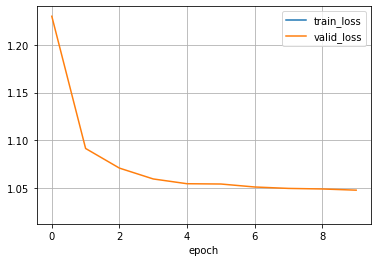

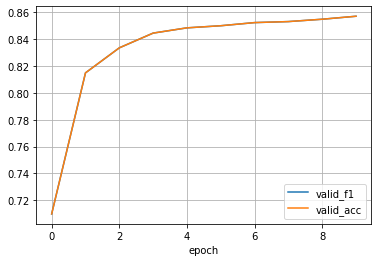

In [23]:
metrics = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")
print(metrics.head())

aggreg_metrics = []
agg_col = "epoch"
for i, dfg in metrics.groupby(agg_col):
    agg = dict(dfg.mean())
    agg[agg_col] = i
    aggreg_metrics.append(agg)

df_metrics = pd.DataFrame(aggreg_metrics)
df_metrics[["train_loss", "valid_loss"]].plot(grid=True, legend=True, xlabel=agg_col)
df_metrics[["valid_f1", "valid_acc"]].plot(grid=True, legend=True, xlabel=agg_col)